In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox
from utils.utils import argnotnan, set_spines_visible
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
@pims.pipeline
def crop(img, bbox):
    """
    Crop the image to select the region of interest
    """
    xmin, xmax, ymin, ymax = bbox
    return img[ymin:ymax, xmin:xmax]


In [3]:
vid_path = "../data/videos/feature-extraction/"
vid_filename = "2024_0331_091926_007_trimmed.mp4"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)
print(vid_props) # ["filename", "fps", "num_frames", "width", "height"]

# Scale D-high UNCLEAR?????
pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 2) # resample to 30 fps
img_save_dir = f"../data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

# IMAGES
img_filenames = sorted([fn for fn in os.listdir(img_save_dir) if fn.endswith("jpg")])
img_filepaths = [os.path.join(img_save_dir, fn) for fn in img_filenames]

# CREATE! mask filenames based every second image frame exported
masks_dir = f"../data/seg_masks/{vid_filename.split('.')[0]}_masks/"
mask_filenames = sorted([fn for fn in os.listdir(masks_dir) if fn.endswith("png")])
mask_filepaths = [os.path.join(masks_dir, fn) for fn in mask_filenames]

print(len(mask_filepaths), len(img_filepaths))

(60, 685, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61
685 685


In [4]:
# Get contours from masks
contour_list = get_contours_from_segmasks(mask_filepaths)
df_stats = get_contour_stats(contour_list, min_area=2200)

# Add infos to dataframe
df_stats["time"] = df_stats.index.values / fps
df_stats[["img_fp", "mask_fp"]] = pd.DataFrame({'img_fp': img_filepaths, 'mask_fp': mask_filepaths})

# Check corresponding lengths
print(len(contour_list), len(mask_filepaths), len(df_stats))
print("centroid isNaN:", df_stats["centroid_x"].isna().sum())

685 685 685
centroid isNaN: 0


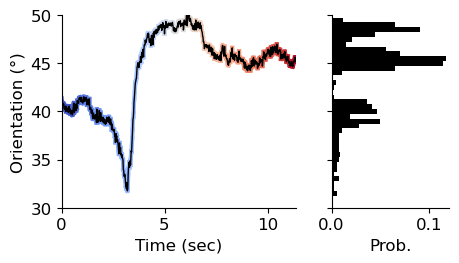

In [5]:
save_path = f"../data/results/egocentric/{vid_filename.split('.')[0]}"
os.makedirs(save_path, exist_ok=True)
SAVE_FIGURES = False

# Get frames and noralized perimeter
variables = ["time", "perimeter", "centroid_dist", "orientation"]
time, perimeter, dcm, orient = df_stats[variables].values.T
nperimeter = perimeter #/ mpp


tc, _ = create_scalarmappable("coolwarm", np.arange(0, len(time)))

fig, ax = plt.subplots(1, 2, figsize=(5,2.5), gridspec_kw={"width_ratios":[2,1]})
plot_colorline(time, orient, colors=tc, ax=ax[0], lw=3)
ax[0].plot(time, orient, "-k", lw=1)
ax[0].set(xlabel="Time (sec)", ylabel="Orientation (°)", xlim=(0, max(time)), ylim=(30,50));

c, bins = np.histogram(orient, bins=np.arange(30,50.2,.5))
ax[1].barh(bins[:-1], c / sum(c), height=.5, color="k");
ax[1].set(xlabel="Prob.", xlim=(0, .12), ylim=(30,50), yticklabels=[]);
fig.savefig(f"{save_path}/orientation_versus_time.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

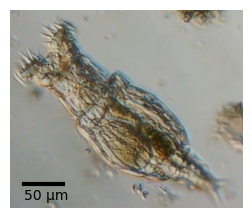

In [6]:
img = cv2.cvtColor(cv2.imread(os.path.join("../data/images/", "frame_00340_bbox_cut.jpeg")), cv2.COLOR_BGR2RGB)
ax_params = dict(xlim=(0, img.shape[1]), ylim=(img.shape[0], 0))

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(30,50), linewidth=3, fontsize=10)
ax.set(**ax_params); ax.axis("off"); ax.invert_yaxis()
fig.savefig(f"{save_path}/Illustration_frame00340.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

In [7]:
# setup params
centers = list(df_stats.loc[:, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df_stats["orientation"].values # np.ones_like(df_stats["orientation"].values) * 45
masks_illustrate = df_stats["mask_fp"].to_list()

# operate on masks and contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, masks_illustrate)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))

centered_contours = normalize_contours_by_centers(rot_contours, centers) 
norm_contours = normalize_contours_by_centers(rot_contours, norm_centers) 


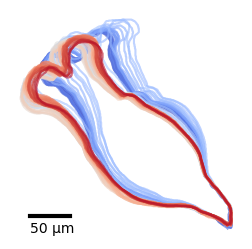

In [8]:
every_nth = 10
subcontours = contour_list[::every_nth]
tcolors, _ = create_scalarmappable("coolwarm", range(len(subcontours)), (0, len(subcontours)))

fig, ax = plt.subplots(figsize=(3,3))
for nth, rcnt in enumerate(subcontours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", lw=1.5, alpha=.6, color=tcolors[nth])

plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(1170,180), linewidth=3, fontsize=10)
ax.set_aspect("equal"); ax.set_axis_off()
fig.savefig(f"{save_path}/Contour-overlay_time_color_code.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

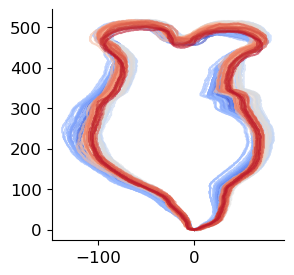

In [9]:
subcontours = norm_contours[::every_nth]
tcolors, _ = create_scalarmappable("coolwarm", range(len(subcontours)), (0, len(subcontours)))

# Plot
fig, ax = plt.subplots(figsize=(3,3))
for nth, rcnt in enumerate(subcontours):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", lw=1.5, alpha=.6, color=tcolors[nth])

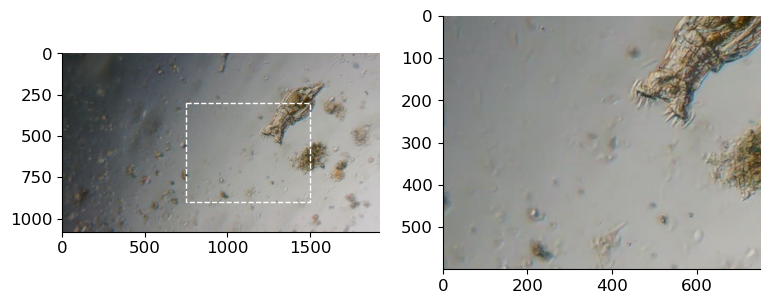

In [10]:
oimg = cv2.cvtColor(cv2.imread(df_stats.loc[0, "img_fp"]), cv2.COLOR_BGR2RGB)

ccenter = (1250, 500) # corona center
xoffset = (500, 500/2)
yoffset = (200, 400)
xmin, xmax = int(ccenter[0]-xoffset[0]), int(ccenter[0]+xoffset[1])
ymin, ymax = int(ccenter[1]-yoffset[0]), int(ccenter[1]+yoffset[1])
bbox = [xmin, xmax, ymin, ymax]
cut_width, cut_height = xmax-xmin, ymax-ymin 

fig, ax = plt.subplots(1,2,figsize=(9,6))
ax[0].imshow(oimg)
ax[1].imshow(oimg[ymin:ymax, xmin:xmax])
plot_bbox(bbox, ax=ax[0])
#ax.set(**ax_params);


# Corona Video

In [11]:
# write video function
SAVE_VIDEO = False
video_save_fpath = f"../data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

img_fp = df_stats["img_fp"].tolist()
bbox = [xmin, xmax, ymin, ymax]; print(bbox)
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)

generate_video_with_text(vid_params, img_fp, text_params, bbox) if SAVE_VIDEO else None

[750, 1500, 300, 900]


In [12]:
from PIL import Image
capture_frames = [[0,30], [40,114], # three particles till 114
                  [198,227], [231,271], [329,351], [489,516], [518,559], # dwelltime!
                  [627,684] # rejection
                  ]


zoom_in_pil = (750, 300, 1500, 900) # (left, upper, right, lower)
food_capture_dir = f"../data/images/{vid_filename.split('.')[0]}_food_capture_frames/"
os.makedirs(food_capture_dir, exist_ok=True)

SAVE_CUT = False
if SAVE_CUT:
    for cut in capture_frames:
        idx = np.arange(cut[0], cut[1]+1)
        cut_imgs = [Image.open(img_fp[i]).crop(zoom_in_pil) for i in idx]
        des_fps = [os.path.join(food_capture_dir, os.path.basename(img_fp[i])) for i in idx]
        for img, des in zip(cut_imgs, des_fps):
            img.save(des)

food_capture_mask_dir = f"../data/seg_masks/{vid_filename.split('.')[0]}_food_capture_frames/"
os.makedirs(food_capture_mask_dir, exist_ok=True)
mask_fp = df_stats["mask_fp"].tolist()
SAVE_CUT_MASK = False
if SAVE_CUT_MASK:
    for cut in capture_frames:
        idx = np.arange(cut[0], cut[1]+1)
        cut_imgs = [Image.open(mask_fp[i]).crop(zoom_in_pil) for i in idx]
        des_fps = [os.path.join(food_capture_mask_dir, os.path.basename(mask_fp[i])) for i in idx]
        for img, des in zip(cut_imgs, des_fps):
            img.save(des)

stacked= list()
for cut in capture_frames:
    idx = np.arange(cut[0], cut[1]+1)
    cut_imgs = [np.array(Image.open(img_fp[i]).crop(zoom_in_pil)) for i in idx]
    stacked.append(np.stack(cut_imgs))


NameError: name 'prts' is not defined

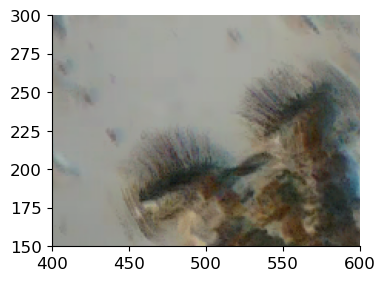

In [13]:
#s_stacked = np.median(stacked[0], axis=0)
s_stacked = np.min(stacked[0], axis=0)
mean_image = np.clip(s_stacked, 0, 255)  # Clip values to the valid range
mean_image = mean_image.astype(np.uint8)
mean_image
plt.imshow(mean_image)
plt.xlim(400,600), plt.ylim(150,300)

# overlay the mask / masybe subtract it to get the cilia field out
# or subtract median from each image, then min, then visualize
# get proper labels in µm on the axes
# plot traced particles
# plot max velo position of particles
for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    plt.scatter(x,y, alpha=.75, s=5)

for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    idx = np.argmax(v)  # have to ignore nanas????
    print(idx)
    plt.scatter(x[idx], y[idx], alpha=1, s=20, marker="*")

In [14]:
df = pd.read_csv("../data/csvs/metadata_food_capture_2024_0331_091926_007_trimmed.csv"); print(df.columns)

# x and y pos
df["cm"] = df["cm"].apply(eval)  # tuples stored as strings, tranform back to tuples
df[["x", "y"]] = pd.DataFrame(df["cm"].to_list(), index=df.index)

# change of x and y
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

xy = [[520, 225],[520, 240], [520, 230],[525,240],[540,240],[500, 210], [510, 210], [475,210], [475,210], [475,210]]
xy_mouth = [550, 150]
x_corona, y_corona = np.mean(xy, axis=0)
x_mouth, y_mouth = x_corona + 30, y_corona -75 
df["rdist"] = np.sqrt((df["x"] - x_corona) ** 2 + (df["y"] - y_corona) ** 2)
df["rdistm"] = np.sqrt((df["x"] - x_mouth) ** 2 + (df["y"] - y_mouth) ** 2)

# group according to particle
grouped = df.groupby("particle").apply(lambda x: x[["x", "y", "v", "rdist", "rdistm"]].to_numpy())
groups = {category: {"x": values.T[0], "y": values.T[1], "v": values.T[2], "rdist": values.T[3], "rdistm": values.T[4]} for category, values in grouped.items()}
prts = df.particle.unique()

#ccols = ["lightsalmon", "teal", "lightblue", "slategrey", "lightgray", "lightgreen", "purple", "crimson","dimgrey"]
global_vminmax = (round(df.v.min(),2), round(df.v.max(),2))
#global_vminmax = (0, 40)
print("max velovity:", global_vminmax, global_vminmax[1] / mpp * fps)
print(len(prts))


Index(['ids', 'fns', 'bbox', 'particle', 'img_fp', 'cm'], dtype='object')
max velovity: (0.0, 57.31) 2084.0
11


In [15]:
# load masks of first images
mask_dir = "../data/seg_masks/2024_0331_091926_007_trimmed_food_capture_frames/"
mask_fps = [f for f in sorted(os.listdir(mask_dir))]
first_frames = df.reset_index().drop_duplicates(subset='particle', keep='first').index.values
mask_fp = [os.path.join(mask_dir, mask_fps[ff]) for ff in first_frames]

contour_list = get_contours_from_segmasks(mask_fp)
df_stats_ = get_contour_stats(contour_list)

centers = list(df_stats_.loc[:, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df_stats_["orientation"].values # np.ones_like(df_stats["orientation"].values) * 45
#rot_angles = df_stats["orientation"].values # np.ones_like(df_stats["orientation"].values) * 45
masks_illustrate = mask_fp#df_stats_["mask_fp"].to_list()

# operate on masks and contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, masks_illustrate)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
norm_centers = list(df_top_bot[["top_x", "top_y"]].itertuples(index=False, name=None))

centered_contours = normalize_contours_by_centers(rot_contours, centers) 
norm_contours = normalize_contours_by_centers(rot_contours, norm_centers) 

# df_stats["fns"] = [os.path.splitext(os.path.basename(f))[0] for f in df_stats["img_fp"].tolist()]
# df = pd.merge(df, df_stats[['fns', 'orientation', 'centroid_x', 'centroid_y']], on='fns', how='left')
# centers = list(df.loc[:, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
# rot_angles = df["orientation"].values


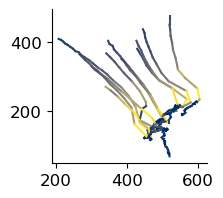

In [16]:
fig, ax = plt.subplots(figsize=(2,2))
for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v))
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax)

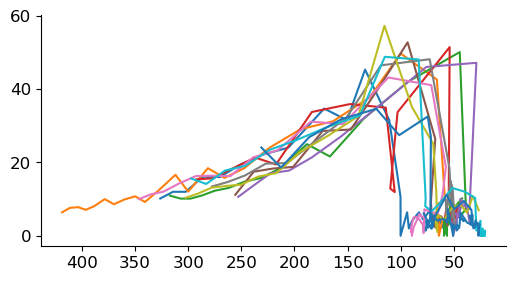

In [17]:
# for c in contour_list:
#     cnt = c.squeeze()
#     plt.figure()
#     plt.plot(cnt[:,0], cnt[:,1])
fig, ax = plt.subplots(figsize=(6,3))
for prt in prts:
    x, y, v, rdist, rdistm = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"], groups[prt]["rdist"], groups[prt]["rdistm"]
    #plt.plot(rdistm[1:], np.diff(v))
    plt.plot(rdistm, v)
ax.invert_xaxis()

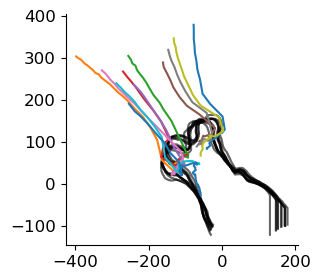

In [18]:
normalize = True

fig, ax = plt.subplots(figsize=(3,3))
for nth, rcnt in enumerate(contour_list):
    x,y = rcnt.squeeze().T
    if normalize:
        x = x - centers[nth][0]
        y = y - centers[nth][1]
    ax.plot(x, y, "-k", lw=1.5, alpha=.6)#, color=tcolors[nth])

for nth, prt in enumerate(prts):
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    if normalize:
        x = x - centers[nth][0] #df.groupby("particle").get_group(prt)["centroid_x"].mean()
        y = y - centers[nth][1] #df.groupby("particle").get_group(prt)["centroid_y"].mean()
    #print(x)
    #c_, _ = create_scalarmappable("cividis", argnotnan(v))
    #plot_colorline(x[1:], y[1:], colors=c_, ax=ax)
    ax.plot(x,y)

- have to cut the masks according to the cut-bbox
### - rotate according to orientation is probably best here


0.0 2083.861641002822


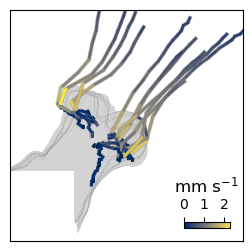

In [19]:
results_save_path = f"../data/results/whirling/{vid_filename.split('.')[0]}"

SAVE_FIGURES = False

ax_params = dict(xlim=(-350, 100), ylim=(-25, 200), xticks=[],yticks=[]) #
normalize = True

fig, ax = plt.subplots(figsize=(3,3))
#tp.plot_traj(ctraj,  label=False, ax=ax, plot_style={"lw" : 1, "color" : "lightgray", "alpha" : .95}); 

for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    if normalize:
        cnt[:,0] = cnt[:,0] - df_stats_.loc[nth, "centroid_x"]
        cnt[:,1] = cnt[:,1] - df_stats_.loc[nth, "centroid_y"]
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")  #, lw=1, edgecolor="gray", linestyle="--")
    ax.plot(cnt[:,0], cnt[:,1], ":", color="gray", alpha=.5, lw=.5)

for nth, prt in enumerate(prts):
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v), global_vminmax)
    if normalize:
        x = x - df_stats_.loc[nth, "centroid_x"]
        y = y - df_stats_.loc[nth, "centroid_y"]
    ax.plot(x[1:], y[1:], "-", lw=3, color="gray", alpha=.5)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=2)

ax.set(**ax_params); 
ax.set_aspect('equal', adjustable='datalim'); ax.invert_xaxis()

vvals = df.v.values / mpp * fps
print(np.nanmin(vvals), np.nanmax(vvals))
# colorbar as inset axes
_, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=global_vminmax)
axin = inset_axes(ax, width="20%", height="3%", loc="lower right", borderpad=.75)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 25, 50])
cbar.set_ticklabels(["0", "1", "2"], fontsize=10)

cbar.set_label("mm s$^{-1}$", fontsize=12)
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
set_spines_visible(ax=ax)
#plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(-100, -110), linewidth=3, fontsize=0)
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

1748.0 ± 202.0
500.3 ± 61.1
[11, 21, 14, 12, 9, 8, 12, 9, 11, 9, 5]


((350.0, 650.0), (100.0, 400.0))

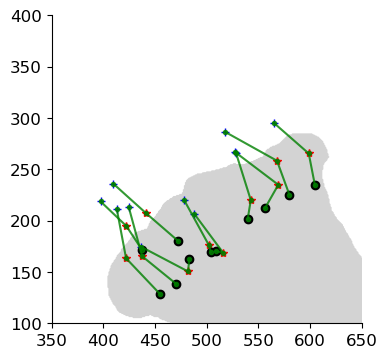

In [21]:
maxv = [np.max(argnotnan(groups[prt]["v"])) for prt in prts]

max_idx = [np.nanargmax(groups[prt]["v"]) for prt in prts]
max_x = [groups[prt]["x"][max_idx[nth]] for nth, prt in enumerate(prts)]
max_y = [groups[prt]["y"][max_idx[nth]] for nth, prt in enumerate(prts)]

max_x_prev = [groups[prt]["x"][max_idx[nth]-1] for nth, prt in enumerate(prts)]
max_y_prev = [groups[prt]["y"][max_idx[nth]-1] for nth, prt in enumerate(prts)]

max_x_next = [groups[prt]["x"][max_idx[nth]+1] for nth, prt in enumerate(prts)]
max_y_next = [groups[prt]["y"][max_idx[nth]+1] for nth, prt in enumerate(prts)]

# x,y position 50ms after the peak
x_at_50 = [groups[prt]["x"][max_idx[nth]+4] for nth, prt in enumerate(prts)]
y_at_50 = [groups[prt]["y"][max_idx[nth]+4] for nth, prt in enumerate(prts)]

print(round(np.mean(maxv) / mpp * fps,0), "±", round(np.std(maxv) / mpp * fps,0))
print(round(np.mean(max_x),1), "±", round(np.std(max_x),1))
print(max_idx)

fig, ax = plt.subplots(figsize=(4,4))

for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")

plt.plot(max_x, max_y, "*r")
plt.plot(max_x_prev, max_y_prev, "+b")
plt.plot(max_x_next, max_y_next, "ok")


max_trajs = []
for nth in range(len(max_x)):
    max_trajs.append([max_x_prev[nth], max_x[nth], max_x_next[nth], max_y_prev[nth], max_y[nth], max_y_next[nth]])

max_trajs = np.array(max_trajs)
for nth in range(len(max_x)):
    plt.plot(max_trajs[nth,:3], max_trajs[nth,3:], ".-g", alpha=.8)

plt.xlim(350,650), plt.ylim(100, 400)

In [22]:

# Project X value onto line defining the coronal plane
x1, y1 = 400, 150  # Example point 1 on the line
x2, y2 = 590, 275  # Example point 2 on the line

# Slope of the line
m = (y2 - y1) / (x2 - x1)

# Intercept of the line
c = y1 - m * x1

def project_point_on_line(x0, y0, m, c):
    # Line equation: y = mx + c
    # Perpendicular slope: -1/m
    # Perpendicular line equation through (x0, y0): y - y0 = (-1/m)(x - x0)
    
    # Solving for intersection (x_proj, y_proj)
    x_proj = (x0 + m * y0 - m * c) / (m**2 + 1)
    y_proj = (m * x_proj + c)
    
    return x_proj, y_proj

distances = []
x_distances = []
for x0, y0 in zip(max_x, max_y):
    x_proj, y_proj = project_point_on_line(x0, y0, m, c)
    distance = np.sqrt((x0 - x_proj)**2 + (y0 - y_proj)**2)
    x_distance = x0 - x_proj # x_distance = abs(x0 - x_proj)
    x_distances.append(x_distance)
    distances.append(distance)

x_distances = np.array(x_distances)

print(round(np.mean(x_distances / mpp),1), "±", round(np.std(x_distances / mpp),1), f"range=[{round(np.min(x_distances / mpp),1)}-{round(np.max(x_distances / mpp),1)}]")
print(round(np.mean(distances),1), "±", round(np.std(distances),1))

max_v_next = [groups[prt]["v"][max_idx[nth]+4] for nth, prt in enumerate(prts)]
#print(max_v_prev)
print(round(np.mean(max_v_next) / mpp * fps,0), "±", round(np.std(max_v_next) / mpp * fps,0))

#max_v_tail = [np.nanmean(groups[prt]["v"][np.arange(max_idx[nth]+4, max_idx[nth]+12)]) for nth, prt in enumerate(prts)]
max_v_tail = [np.nanmean(groups[prt]["v"][max_idx[nth]+5:]) for nth, prt in enumerate(prts)]
(1000/fps) * 3

round(np.mean(max_v_next) / mpp * fps,0)/1748.0*100
print(round(np.mean(max_v_tail) / mpp * fps,0)/1748.0*100)
print(np.mean(max_v_tail) / mpp * fps, np.std(max_v_tail) / mpp * fps)

x_distances_at_50 = []
for x0, y0 in zip(x_at_50, y_at_50):
    x_proj, y_proj = project_point_on_line(x0, y0, m, c)
    distance = np.sqrt((x0 - x_proj)**2 + (y0 - y_proj)**2)
    x_distance = x0 - x_proj # x_distance = abs(x0 - x_proj)
    x_distances_at_50.append(x_distance)

x_distances_at_50 = np.array(x_distances_at_50)
print(round(np.mean(x_distances_at_50 / mpp),1), "±", round(np.std(x_distances_at_50 / mpp),1), f"range=[{round(np.min(x_distances_at_50 / mpp),1)}-{round(np.max(x_distances_at_50 / mpp),1)}]")


4.3 ± 7.8 range=[-8.3-16.1]
22.1 ± 15.1
154.0 ± 73.0
12.16309606081548
176.058726970155 71.7826924589208
11.9 ± 3.7 range=[7.2-21.2]


(0.0, 57.31)


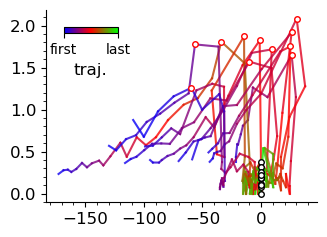

In [23]:
print(global_vminmax)
fig, ax = plt.subplots(figsize=(3.5,2.5))

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats_.loc[nth, "centroid_x"]
        x = x - x[-1]
    #ax.plot(x / mpp, v, "-", lw=1.5, color=ccols[prt-1], alpha=.8)
    c_, _ = create_scalarmappable("brg", np.arange(0, len(x)))
    plot_colorline(x / mpp, v / mpp * fps / 1000, colors=c_, alpha=.8)

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats_.loc[nth, "centroid_x"]
        x = x - x[-1]
    ax.plot(x[np.where(v==np.nanmax(v))[0][0]] / mpp, np.nanmax(v) / mpp * fps / 1000, "o", mfc="w", ms=4, color="r")
    ax.plot(x[-1] / mpp, v[-1] / mpp * fps / 1000, "o", mfc="w", ms=4, color="k")
    #ax.plot(x[1] / mpp, v[1], "o", mfc="w", ms=4, color=ccols[prt-1])

_, sm = create_scalarmappable("brg", np.arange(0,51))
axin = inset_axes(ax, width="20%", height="3%", loc="upper left", borderpad=1.05)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 50])
cbar.set_ticklabels(["first", "last"], fontsize=10)

cbar.set_label("traj.", fontsize=12)
axin.xaxis.set_ticks_position("bottom")
axin.xaxis.set_label_position("bottom")

#ax.set(xlabel=("X (µm)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2));
ax.minorticks_on()
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_X.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

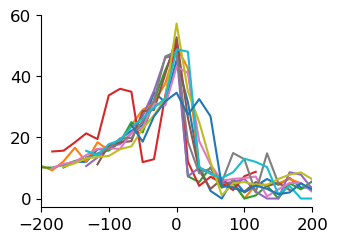

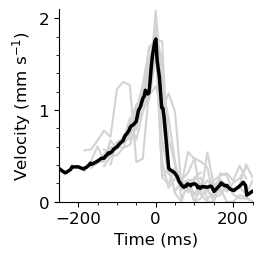

In [24]:
normalized_data = []

for prt in prts:
    v = groups[prt]["v"]
    v_non_nan = v[~np.isnan(v)]#v.dropna().values
    ctime = np.arange(len(v_non_nan))
    idx_max = np.argmax(v_non_nan)
    timeidx = ctime[idx_max]
    
    # Normalize time
    norm_time = (ctime - timeidx) / fps * 1000
    normalized_data.append((norm_time, v_non_nan))

fig, ax = plt.subplots(figsize=(3.5,2.5))

for t, v in normalized_data:
    ax.plot(t, v)

ax.set(xlim=(-200, 200))



from scipy.interpolate import interp1d

all_times = np.concatenate([t for t, _ in normalized_data])
common_time = np.linspace(all_times.min(), all_times.max(), num=400)  # Adjust the number of points as needed

# Interpolate signals to common time
interpolated_signals = []

for t, v in normalized_data:
    interpolator = interp1d(t, v, bounds_error=False, fill_value=np.nan)
    interpolated_signal = interpolator(common_time)
    interpolated_signals.append(interpolated_signal)

# Convert to DataFrame for easier manipulation
interpolated_df = pd.DataFrame(interpolated_signals).T
interpolated_df.columns = prts

# Compute the mean signal, ignoring NaNs
mean_signal = interpolated_df.median(axis=1, skipna=True)

fig, ax = plt.subplots(figsize=(2.5,2.5))

for t, v in normalized_data:
    ax.plot(t, v / mpp * fps / 1000, lw=1.5, color="lightgray")  # Plot original signals with some transparency

ax.plot(common_time, mean_signal / mpp * fps / 1000, color="k", linewidth=2.5, label='Mean Signal')
ax.set(xlabel=("Time (ms)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2), xlim=(-250, 250));
ax.minorticks_on()
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_time_aligned_to_maxV.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

# SAVE TH DATAFRAME AND LOAD IN INTO OTHER NOTEBOOK
- trajectories dont look too good and rotation proved difficult...

(0.0, 250.0)

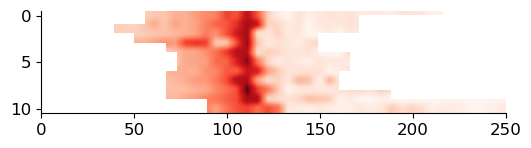

In [30]:
plt.imshow(interpolated_df.to_numpy().T, aspect=5, cmap="Reds")
plt.xlim(0,250)

# Particle tracking

In [35]:
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
import trackpy as tp

# POTENTIALLY Scale D-mid
# pixel_per_real_width = .75
# mpp = 1.333  # microns_per_pixel
# print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

In [36]:
# Read-in
img_seq_folder = f"{img_save_dir}/*.jpg"
frames = pims.as_grey(crop(pims.open(img_seq_folder), bbox))

img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))


real width (µm):  454.55 
real height (µm): 363.64


In [37]:
from shapely.geometry import Point, Polygon

def is_point_in_polygon(x, y, polygon):
    point = Point(x, y)
    return polygon.contains(point)

# seg mask as polygon
# binary_mask = np.zeros((100, 100), dtype=np.uint8)
# cv2.rectangle(binary_mask, (20, 20), (80, 80), 255, -1)
# contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# polygons = [Polygon(contour.squeeze()) for contour in contours if contour.size >= 6]

n features -  105
rotifer 57 
detrituts 22


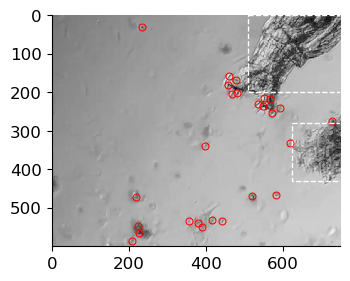

In [38]:
locate_params = {
    "diameter" : 13,
    "threshold" : 6,
    "invert" : True,
}
frame_nr = 1
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# # Rotifer exclude
rotifer_bbox = [510, img_width, 0, 200]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]

# Detritus exclude
detritus_bbox = [625, img_width, 280, 430]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

fig, ax = plt.subplots()
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# # BBoxes to exclude
plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)

#ax.set(xlim=(400, img_width), ylim=(0, 300))

In [39]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)

mask_polygon = Polygon([(550, 0), (390, 200), (600, 270), (img_width, 0)])
fbatch['inside_mask'] = fbatch.apply(lambda row: is_point_in_polygon(row['x'], row['y'], mask_polygon), axis=1)
fbatch = fbatch[~fbatch['inside_mask']]
fbatch = fbatch.drop(columns=['inside_mask'])


#rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
#fbatch = fbatch[~rotifer_condition]

detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]

fbatch


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
8,31.913491,235.483007,710.267629,2.157544,0.130246,40.597171,-14429.0260,0.174739,0
16,52.528455,731.136104,1214.623479,3.334553,0.351531,48.643458,-12037.1139,0.095539,0
21,71.062722,737.221686,1440.285233,3.617013,0.052498,36.574028,-13520.1001,0.132880,0
25,76.225152,708.595480,1262.169716,3.301344,0.599302,43.888834,-12034.3519,0.095489,0
32,97.752641,702.254695,1246.442883,2.717261,0.139496,47.180496,-12950.3010,0.115531,0
...,...,...,...,...,...,...,...,...,...
75516,533.607509,355.103754,547.601182,2.784035,0.322559,19.063249,-17553.8963,-2.313357,684
75517,538.843640,378.781297,743.466724,3.004438,0.232480,22.427352,-15589.0794,0.289838,684
75518,548.789103,390.089244,795.797213,3.253137,0.163967,19.063249,-15384.9077,0.259495,684
75519,564.962330,226.482718,962.507197,3.133533,0.413544,29.903136,-10377.5321,0.072737,684


In [40]:
link_params = {
    "search_range" : 40,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(10); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 851
10
N Before: 851 
 N after filtering: 260


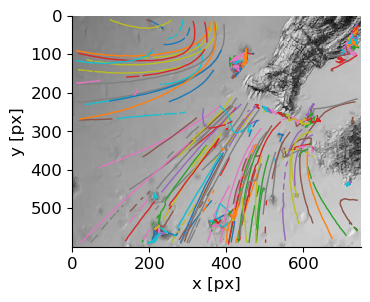

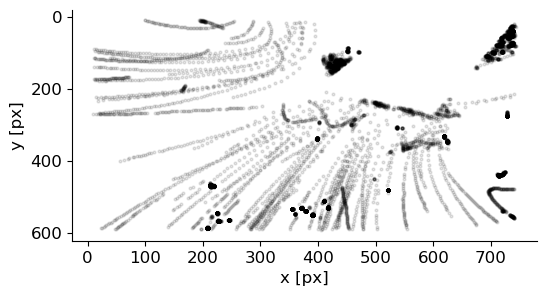

In [41]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots()
tp.plot_traj(trajs, superimpose=frames[frame_nr], label=False, ax=ax);#, label=True

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"});
#ax.set(**ax_params); ax.invert_yaxis(); ax.invert_xaxis()

# reject based on velocity / acceleration here?!

In [42]:
stats, frames_present = get_trajectory_stats(trajs);

# Spatial filtering of trajectories
# to_drop = stats.loc[(stats["x_avg"] > 520) & (stats["y_avg"] < 150), "particle"].to_list()
# trajs_ = trajs[~trajs['particle'].isin(to_drop)]

# Re-Calculate stats and reject more based on std of spatial position
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 10) | (stats.y_std <= 14)  #reject_idx = (stats.x_std < 20) | (stats.y_std < 20)
reject_prts = stats.particle[reject_idx].to_numpy()  #reject_prts = np.append(reject_prts, [56, 81]) 

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
num_particles_rejected = traj_rejected.particle.nunique()
print("number of particles (original):", num_ori_particles, 
      "\nnumber of rejected particles:", num_particles_rejected, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj)
print(len(stats))

number of particles = number of trajectories: 260
number of particles = number of trajectories: 260
number of particles (original): 260 
number of rejected particles: 194 
number of particles remaining: 66
number of particles = number of trajectories: 66
66


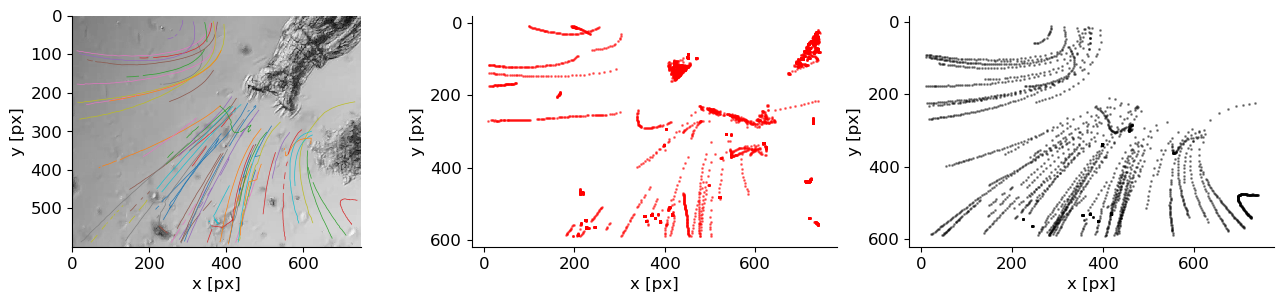

In [43]:
fig, ax = plt.subplots(1,3, figsize=(16, 3))
tp.plot_traj(ctraj, superimpose=frames[0], label=False, ax=ax[0], plot_style={"lw" : .5}); #ax[0].set(**ax_params); 
tp.scatter(traj_rejected, ax=ax[1], plot_style={"ms" : 1, "alpha" : .5, "color" : "r", "label" : "rejected"})
tp.scatter(ctraj, ax=ax[2], plot_style={"ms" : 1, "alpha" : .4, "color" : "k", "label" : "accepted"});

In [44]:
displacement_array = reindex_calculate_displacement_and_stack(ctraj, np.arange(0, len(frames)))
displacement_array = (displacement_array)
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)
df_disp

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.974216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.156262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.800363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.816477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.815740,NaN,NaN,NaN,NaN,4.441829,11.553823,19.124387,11.171421
681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.374863,NaN,NaN,NaN,NaN,3.677074,12.309703,20.946502,11.171421
682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20.385752,NaN,NaN,NaN,NaN,4.359987,12.083347,23.192590,0.361808
683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,24.312844,NaN,NaN,NaN,NaN,4.406861,12.938838,23.440438,0.134875


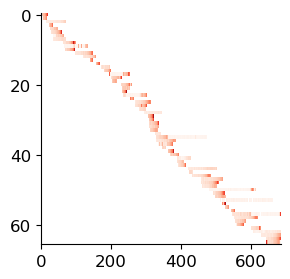

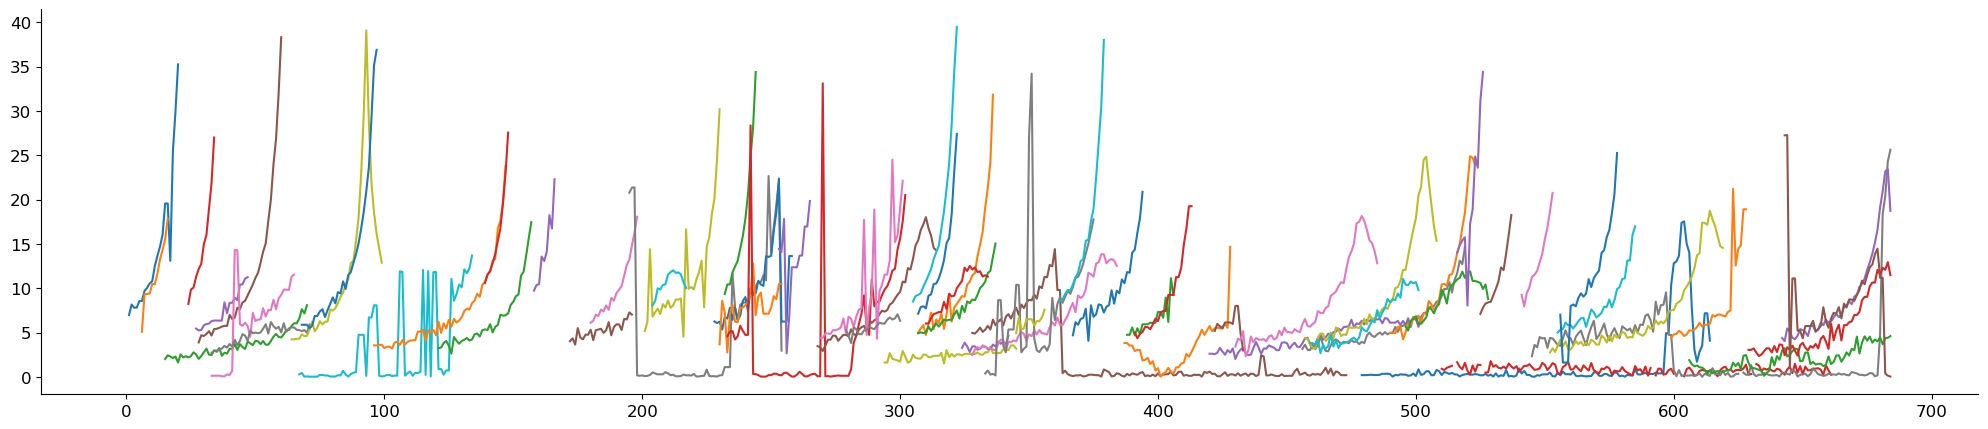

In [60]:
plt.subplots()
plt.imshow(df_disp.values.T, aspect=10, cmap="Reds", interpolation='none', vmin=0, vmax=np.nanmax(df_disp.values))#, extent=[0, fr_time[-1], displacement_array.shape[0], 0]
#displacement_array
plt.subplots(figsize=(25,5))
plt.plot(df_disp.values); # displacement_array.T

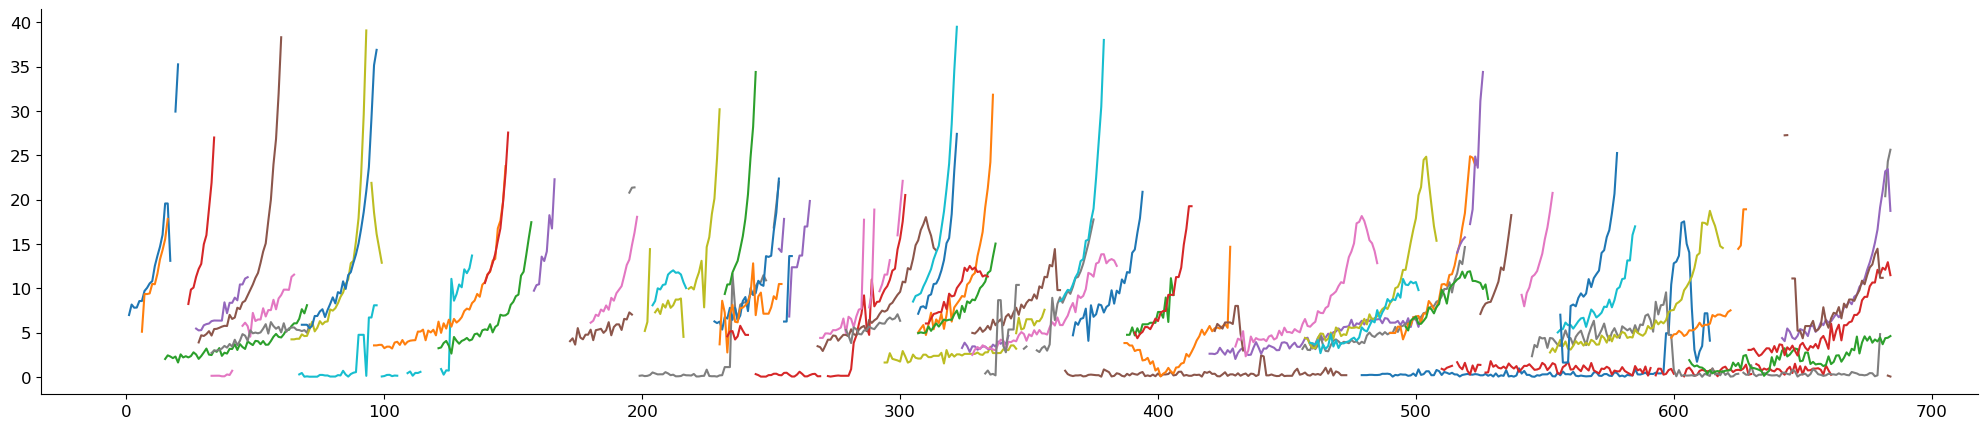

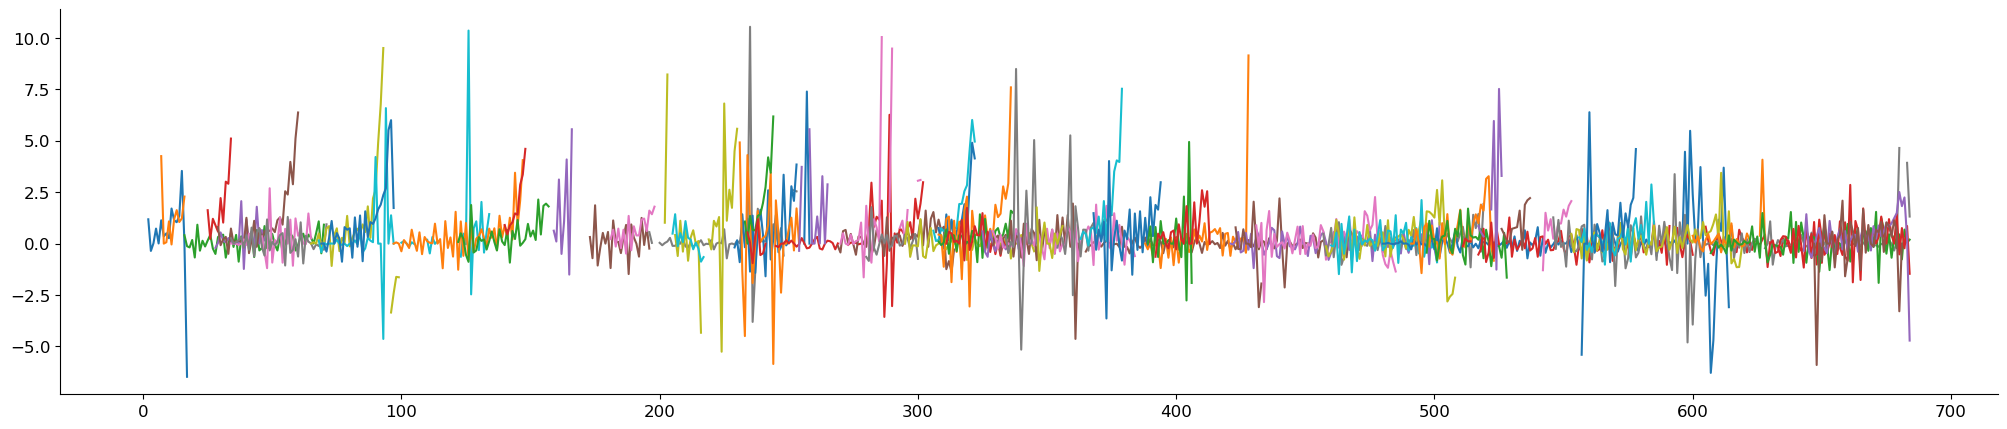

In [57]:
df_masked = df_disp.mask((df_disp.diff()>=11) | (df_disp.diff() *-1 >=7.5))
df_masked

plt.subplots(figsize=(25,5))
plt.plot(df_masked.values); # displacement_array.T

plt.subplots(figsize=(25,5))
plt.plot(df_masked.diff().values);

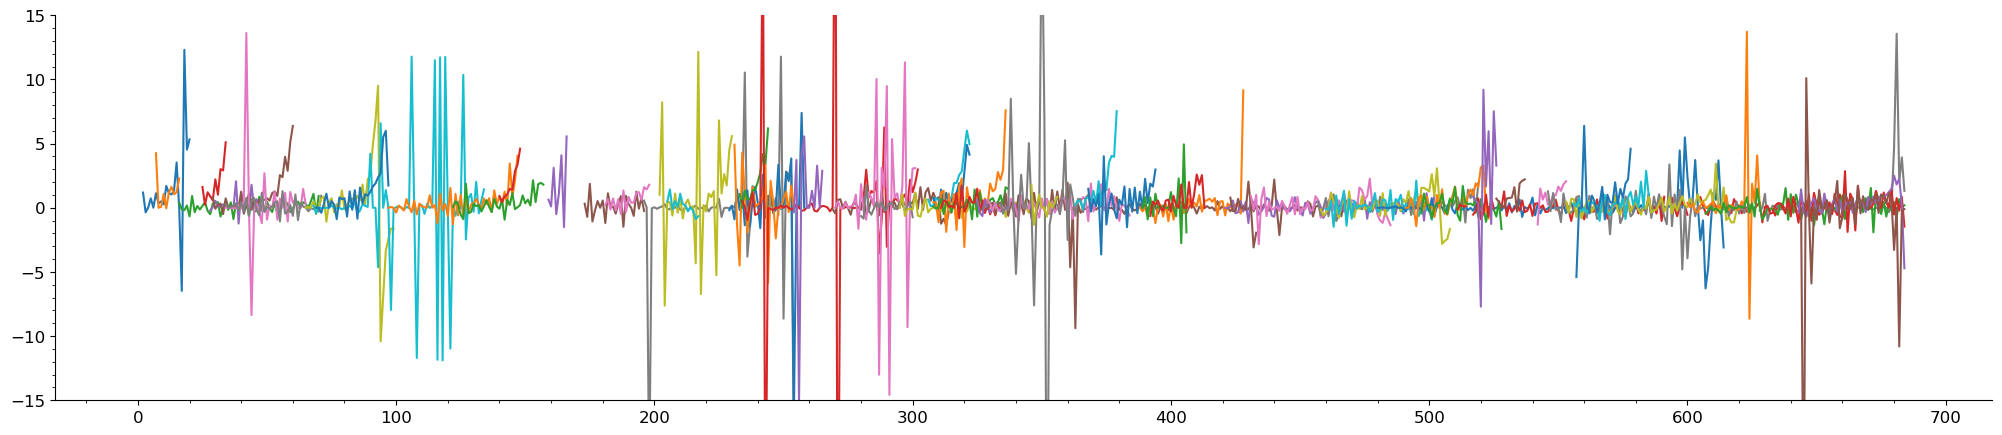

In [47]:
plt.subplots(figsize=(25,5))
plt.plot(df_disp.diff().values);
plt.ylim(-15,15)
plt.minorticks_on()

In [48]:
corona_center = (570, 200)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
ctraj['velocity'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj['rdist'] = np.sqrt((ctraj['x'] - corona_center[0]) **2 + (ctraj['y'] - corona_center[1]) **2)
bins = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), 30)
ctraj['rbin'] = pd.cut(ctraj['rdist'], bins)
ctraj_ = ctraj.dropna()
bin_stats = ctraj_.groupby('rbin', observed=True)['velocity'].agg(['mean', 'std', 'count'])
bin_centers = [round(interval.mid, 1) for interval in bin_stats.index.categories]
ctraj['velocity'].max()

39.5102928391546

In [53]:
from scipy.interpolate import griddata
grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 10), np.arange(0, img_height, 10))

# Interpolate velocities onto grid
grid_u = griddata(ctraj[["x", "y"]].values, ctraj["dx"].values, (grid_x, grid_y), method='linear')
grid_v = griddata(ctraj[["x", "y"]].values, ctraj["dy"].values, (grid_x, grid_y), method='linear')

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)

print(np.nanmin(omega), np.nanmax(omega))

-1.3386490764745684 1.9202731231066497


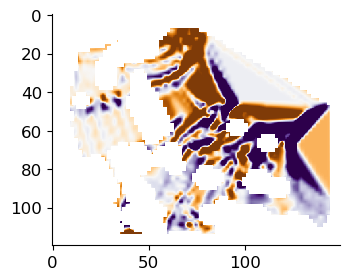

In [55]:
vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=False, sigma=1)

plt.figure()
plt.imshow(vort_map, vmin=-.25,vmax=.25, cmap="PuOr", alpha=1)

(48.999999999999986, 735.0, 585.0, 4.421279921585576)

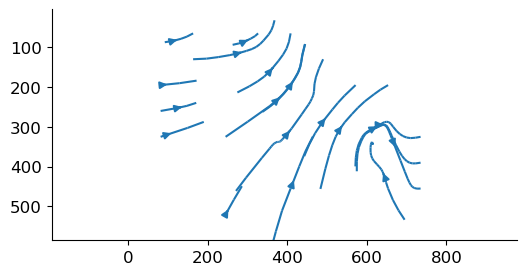

In [51]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v, density=.35, broken_streamlines=False)
plt.gca().invert_yaxis()
plt.axis("equal")

0.0 2083.861641002822


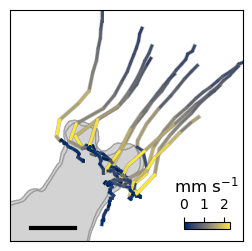

In [52]:
annot_prts = df.particle.unique()
#ax_params = dict(xlim=(310,640), ylim=(90, 420), xticks=[],yticks=[], xlabel="", ylabel="") #
ax_params = dict(xlim=(310-50,640+50), ylim=(90-50, 420+50), xticks=[],yticks=[], xlabel="", ylabel="") #

fig, ax = plt.subplots(figsize=(3, 3))
#tp.plot_traj(ctraj,  label=False, ax=ax, plot_style={"lw" : 1.5, "color" : "lightgray", "alpha" : 1}); #ax[0].set(**ax_params); superimpose=frames[0],

for nth, rcnt in enumerate(contour_list[:2]):
    x,y = rcnt.squeeze().T
    ax.plot(x, y, "-", lw=1, alpha=.6, color="gray")#, color=tcolors[nth])
    ax.fill_between(x, y, facecolor="lightgray")  #, lw=1, edgecolor="gray", linestyle="--")
    ax.plot(x, y, ":", color="gray", alpha=.5, lw=.5)

#plt.streamplot(grid_x, grid_y, grid_u, grid_v, density=.3, broken_streamlines=False, color="slategray")

for prt in annot_prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v)) # cividis
    ax.plot(x[1:], y[1:], "-", lw=3, color="gray", alpha=.5)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=2)
    #plt.scatter(x[1:], y[1:], c=c_, s=10, edgecolors=c_, zorder=3)

#plt.streamplot(grid_x, grid_y, grid_u, grid_v, density=.45, broken_streamlines=False, linewidth=.75, color="gray", zorder=0)

ax.set(**ax_params); ax.set_aspect('equal', adjustable='datalim'); 
ax.invert_xaxis()
set_spines_visible(ax=ax)


vvals = df.v.values / mpp * fps
print(np.nanmin(vvals), np.nanmax(vvals))
# colorbar as inset axes
_, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=global_vminmax)
axin = inset_axes(ax, width="20%", height="3%", loc="lower right", borderpad=.75)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 25, 50])
cbar.set_ticklabels(["0", "1", "2"], fontsize=10)

cbar.set_label("mm s$^{-1}$", fontsize=12)
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
set_spines_visible(ax=ax)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(570, 65), linewidth=3, fontsize=0)
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

In [ ]:
ctraj['velocity'] = ctraj['velocity'].mask(ctraj["velocity"]>=30)
ctraj = ctraj.dropna(subset="velocity")

In [ ]:
grouped.get_group(2)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,dx,dy,velocity,rdist,rbin
31,565.456059,227.255326,1098.683809,3.488282,0.337861,25.236080,-9491.8898,0.064344,1,2,0.165688,-0.341828,0.379867,501.030979,"(485.928, 508.958]"
63,565.352127,227.221810,1083.322717,3.401950,0.308305,24.870339,-9580.5237,0.065068,2,2,-0.033517,-0.103932,0.109202,500.978108,"(485.928, 508.958]"
87,565.413598,226.564448,1032.850558,3.436185,0.380227,24.504599,-10017.5811,0.068970,3,2,-0.657362,0.061471,0.660230,501.472907,"(485.928, 508.958]"
112,565.330779,227.284477,1097.952329,3.431203,0.319974,24.138859,-9537.8059,0.064763,4,2,0.720029,-0.082818,0.724777,500.919662,"(485.928, 508.958]"
139,565.439775,226.364659,1105.267134,3.481681,0.374628,25.601820,-10145.2874,0.070320,5,2,-0.919818,0.108996,0.926253,501.628824,"(485.928, 508.958]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,585.747562,208.018359,641.218224,2.975517,0.215413,20.233507,-15948.9465,0.372315,146,2,-0.030535,0.483301,0.484265,528.991389,"(508.958, 531.988]"
3992,585.990962,207.877725,691.985932,3.183807,0.290485,18.026215,-15844.2872,0.345705,147,2,-0.140635,0.243401,0.281108,529.265118,"(508.958, 531.988]"
4026,585.263896,208.098219,681.685237,3.269757,0.392240,18.026215,-15870.4661,0.352044,148,2,0.220494,-0.727066,0.759765,528.584117,"(508.958, 531.988]"
4049,585.225928,207.946746,683.892529,3.240495,0.330432,18.394097,-15871.2961,0.351753,149,2,-0.151474,-0.037968,0.156160,528.660169,"(508.958, 531.988]"


# mask out acceleration values above and bexond
- df_masked = df_disp.mask((df_disp.diff()>=11) | (df_disp.diff() *-1 >=7.5))
- df["v"].diff()!

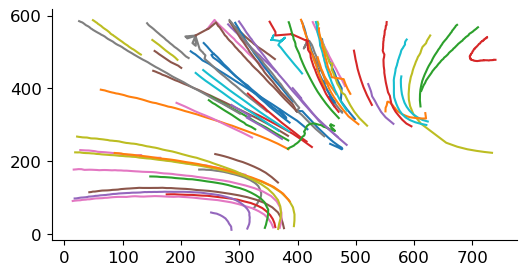

In [ ]:
grouped = ctraj.groupby("particle")
prts = ctraj["particle"].unique()

fig, ax = plt.subplots()
for prt in prts:
    x, y = grouped.get_group(prt)["x"], grouped.get_group(prt)["y"]
    ax.plot(x,y)

In [ ]:
n_frames = ctraj_.groupby('particle')['frame'].count()
n_frames.sort_values(ascending=False)

particle
333     465
35      322
41      288
34      239
40      206
       ... 
1182     10
548       9
933       9
424       9
346       9
Name: frame, Length: 126, dtype: int64

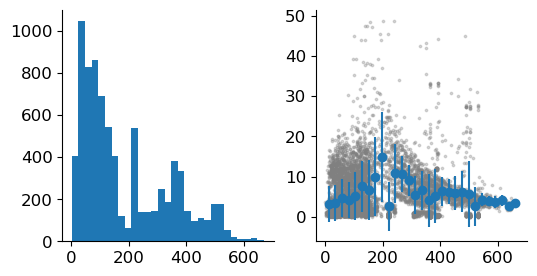

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')


# Image based capture explore

noteable frames:
start with lower interframe numbers so to check whether it works
- 57-82
- 91-132
- 201-242, handled and rejected, but rotifer movement
- 237-322, multiple catch events, first ones 237-285
- 333-360
- 366-411
- 498-544
- 629-664

In [ ]:
img_seq_folder = f"{img_save_dir}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))

# framew = (57,82)
# pre = np.arange(52,56)
# normed_frame = frames[np.arange(59,61)][ymin:ymax, xmin:xmax] - np.mean(np.stack(frames[pre], axis=-1), axis=-1)[ymin:ymax, xmin:xmax]
# print(np.min(normed_frame), np.max(normed_frame), np.percentile(normed_frame, [5, 95]))
# plt.imshow(normed_frame, cmap="gray")

frame_windows = [(57,82), (91,132), (201,242), (237,322), (333,360), (366,411), (498,544), (629,664)];  # cut = 10
stacked_norm = []

for framew in frame_windows:
    n_frames = np.diff(framew)
    window_indices = np.arange(framew[0], framew[1], 1)
    avg_pre = np.mean(np.stack(frames[window_indices[0]-5:window_indices[0]], axis=-1), axis=-1)[ymin:ymax, xmin:xmax]
    zprojs = []
    for wi in window_indices:
        
        stacked = np.stack(frames[wi][ymin:ymax, xmin:xmax]) - avg_pre #frames[window_indices[0]][ymin:ymax, xmin:xmax]
        zprojs.append(stacked); #print(stacked.shape)

    stacked = np.stack(zprojs, axis=-1); del zprojs
    norm_stack = np.min(stacked, axis=-1)  # #norm_stack = np.mean(np.diff(stacked, axis=-1), axis=-1)
    stacked_norm.append(norm_stack)
    
    plt.figure(figsize=(10,10))
    plt.imshow(norm_stack, cmap="gray")
    plt.title(f"frames {framew}, n={n_frames}")


plt.figure(figsize=(10,10))
plt.imshow(np.mean(np.stack(stacked_norm, axis=-1) ,axis=-1), cmap="gray")
plt.title(f"frames {framew}, n={n_frames}")


# temporal cut to RGB image

In [ ]:
# cuts = [[38, 41.5], [43.5, 47], [47.75, 51]]
# indices = []
# for cut in cuts:
#     indices.append(df_stats[df_stats["orientation"].between(cut[0], cut[1])].index.values)
#     print(len(indices[-1]))

# ccolor = ["r", "b", "k"]
# fig, ax = plt.subplots(figsize=(3,3))
# for inds, c in zip(indices, ccolor):
#     for nth, ind in enumerate(inds[::2]):
#         rcnt = contour_list[ind]
#         x,y = rcnt.squeeze().T
#         ax.plot(x, y, "-", lw=1, alpha=.4, color=c)

# img_seq_folder = f"{img_save_dir}/*.jpg"
# frames = pims.as_grey(pims.open(img_seq_folder))
# avg = np.mean(frames[1,3,6], axis=-1)

# zprojs = []
# for nth in range(3):
#     stacked = np.stack(frames[indices[nth]]) - frames[indices[nth][0]]
#     print(stacked.shape)
#     zprojs.append(np.min(stacked, axis=0))

# for zproj in zprojs:
#     plt.figure()
#     plt.imshow(zproj, "Reds_r")
    
# norm_zprojs = [1 - (proj - np.min(proj)) / (np.max(proj) - np.min(proj)) for proj in zprojs]

# # RGB stack
# rgb = np.stack(norm_zprojs, axis=-1)
# plt.figure(figsize=(9,9))
# plt.imshow(rgb)
# plt.gca().invert_yaxis()

# plt.figure(figsize=(9,9))
# plt.imshow(rgb)
# plt.xlim(900,1500); plt.ylim(300, 900)